# Final Project - Training Data

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
# Loading Data
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

print(data_train.shape, labels_train.shape)

(270000, 8443) (8443,)


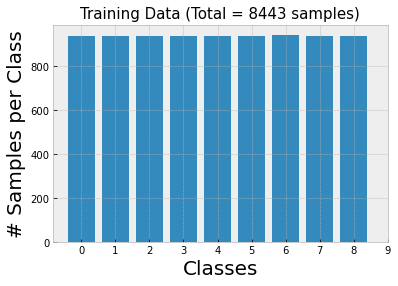

In [2]:
# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

In [5]:
# Labels Integer Encoding

labels_names = ['a',
                'b',
                'c',
                'd',
                'e',
                'f',
                'g',
                'h',
                'i']

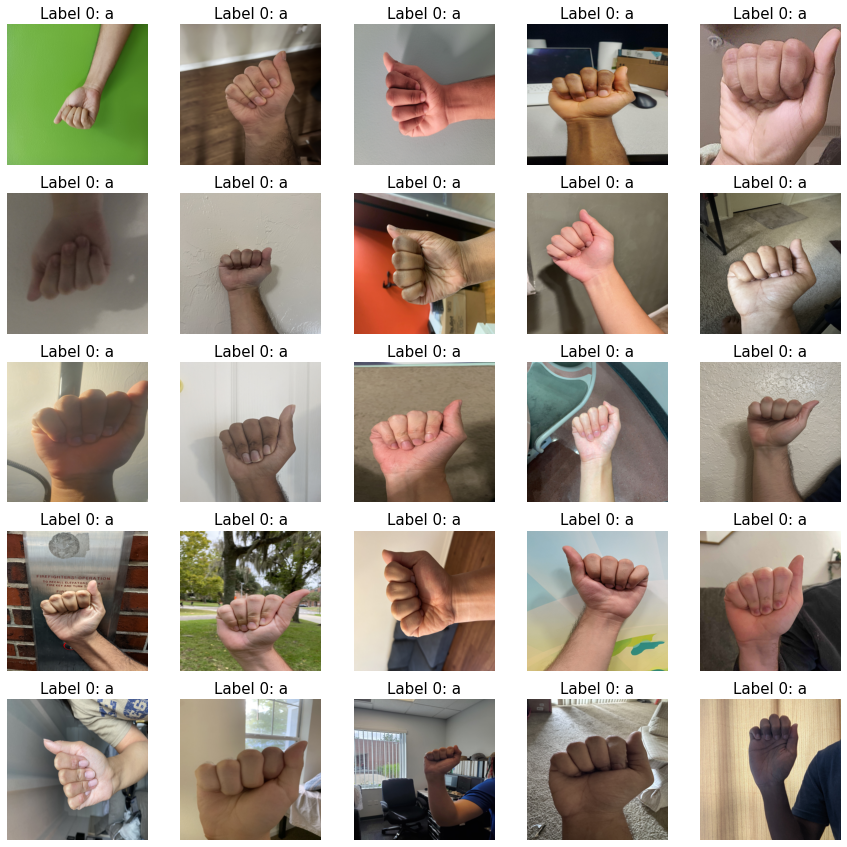

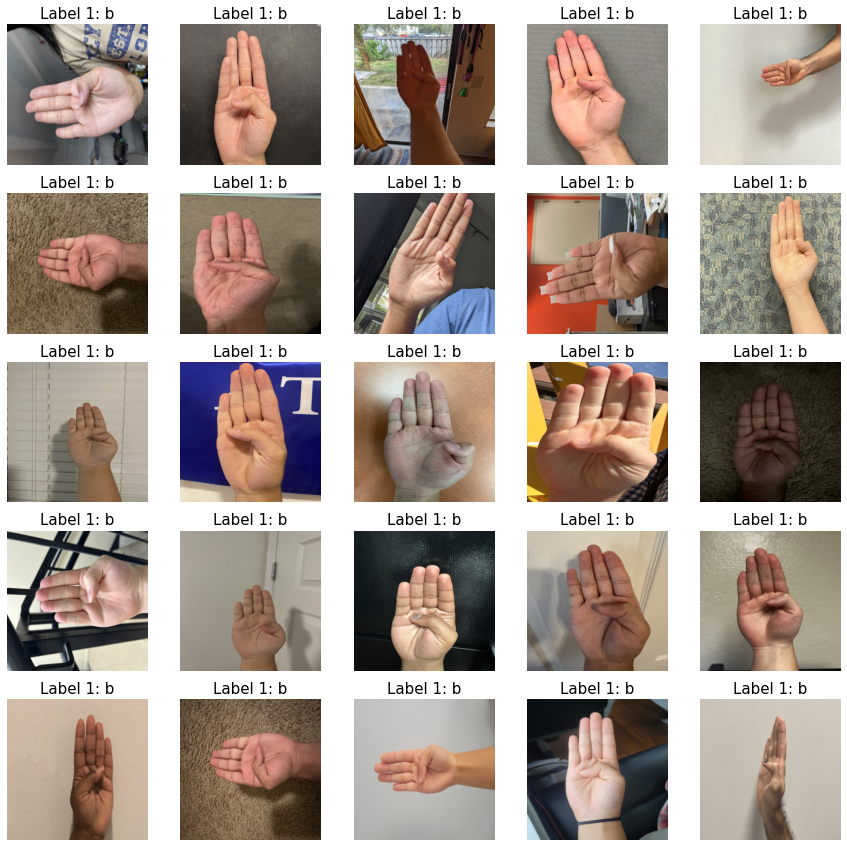

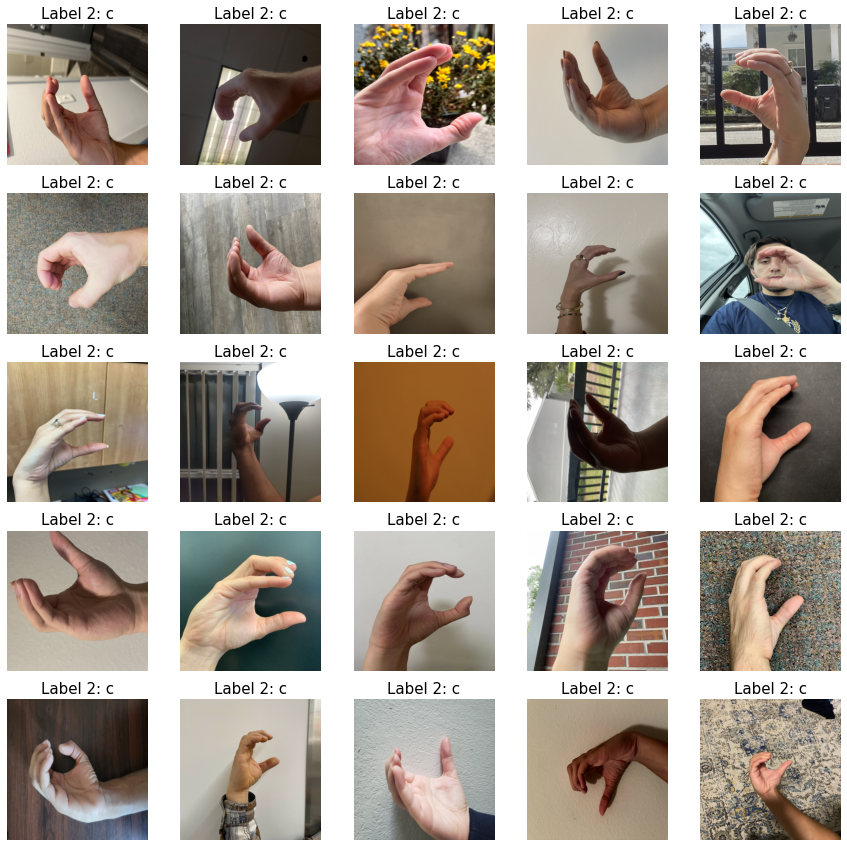

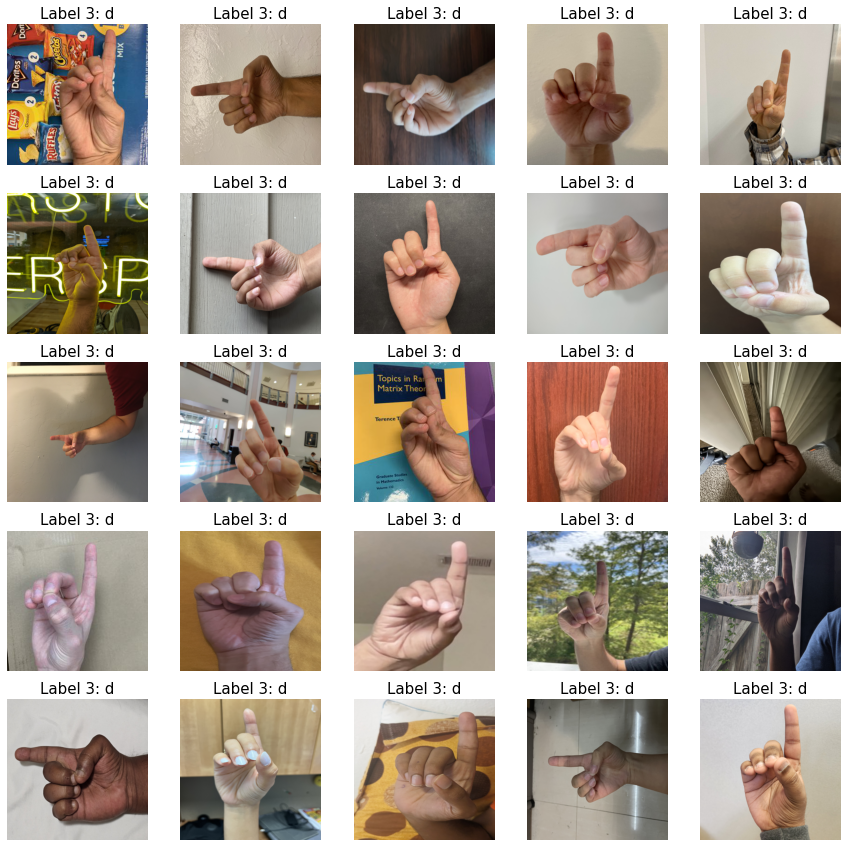

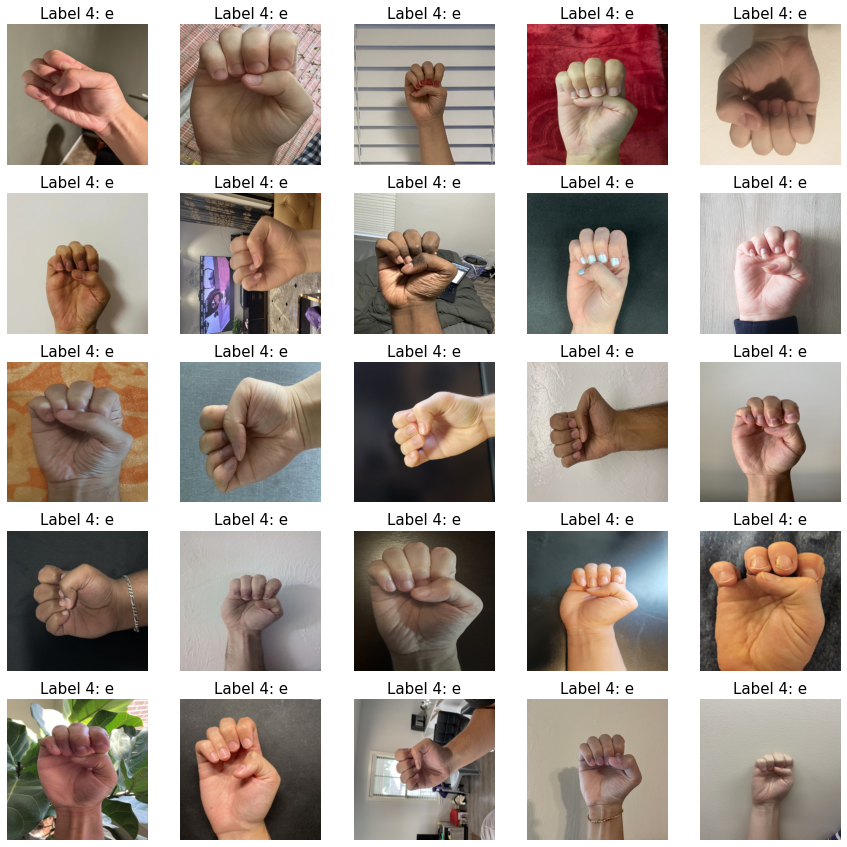

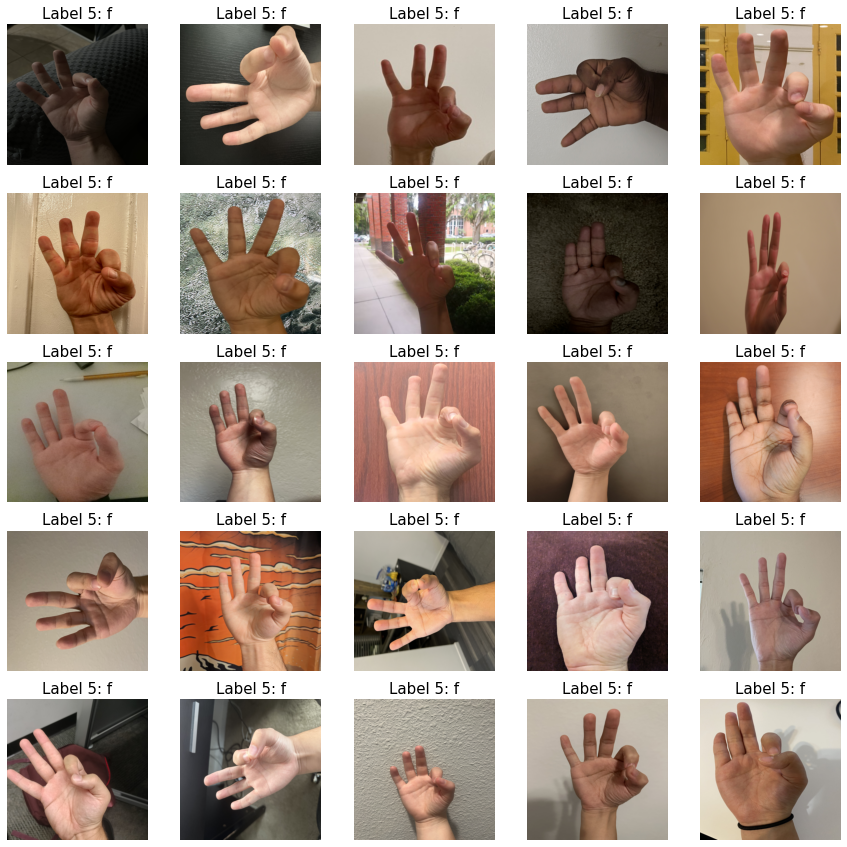

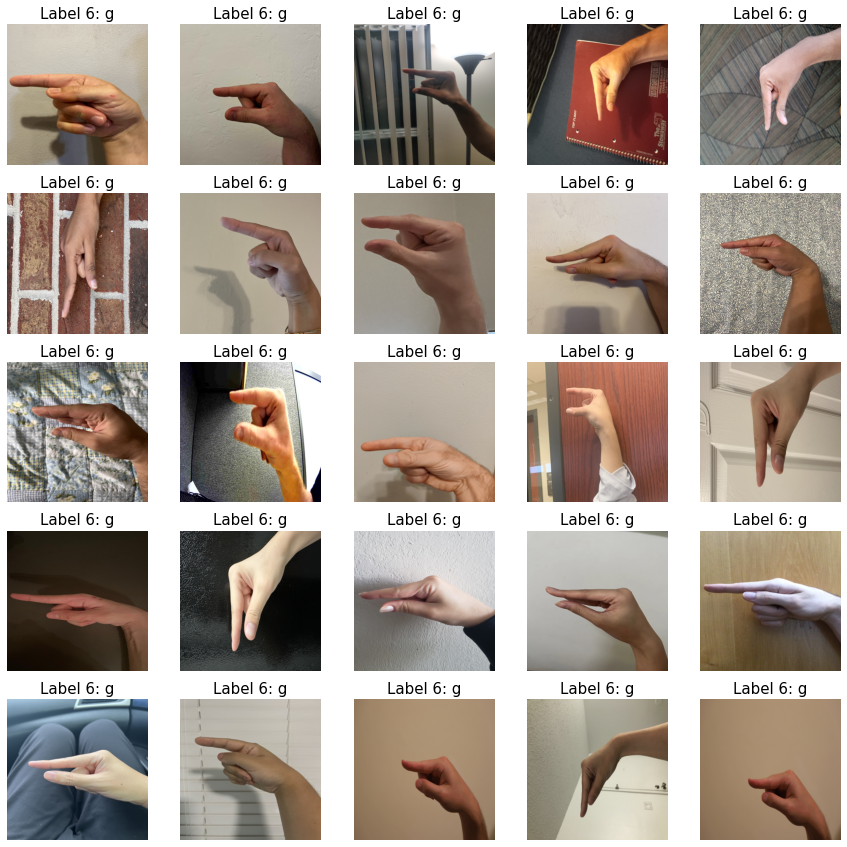

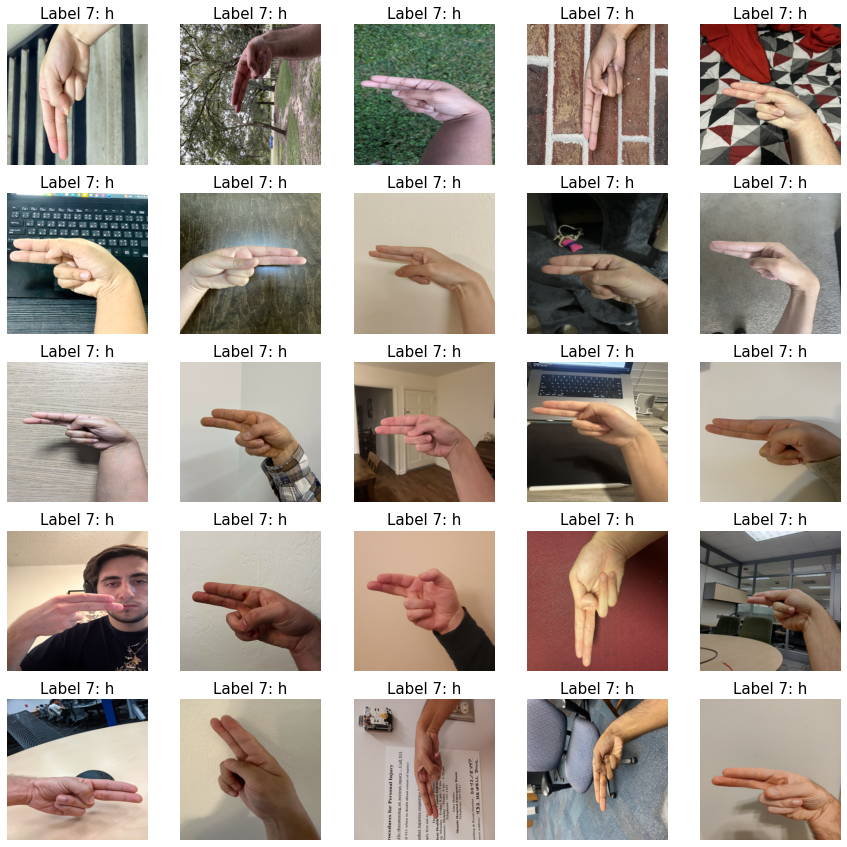

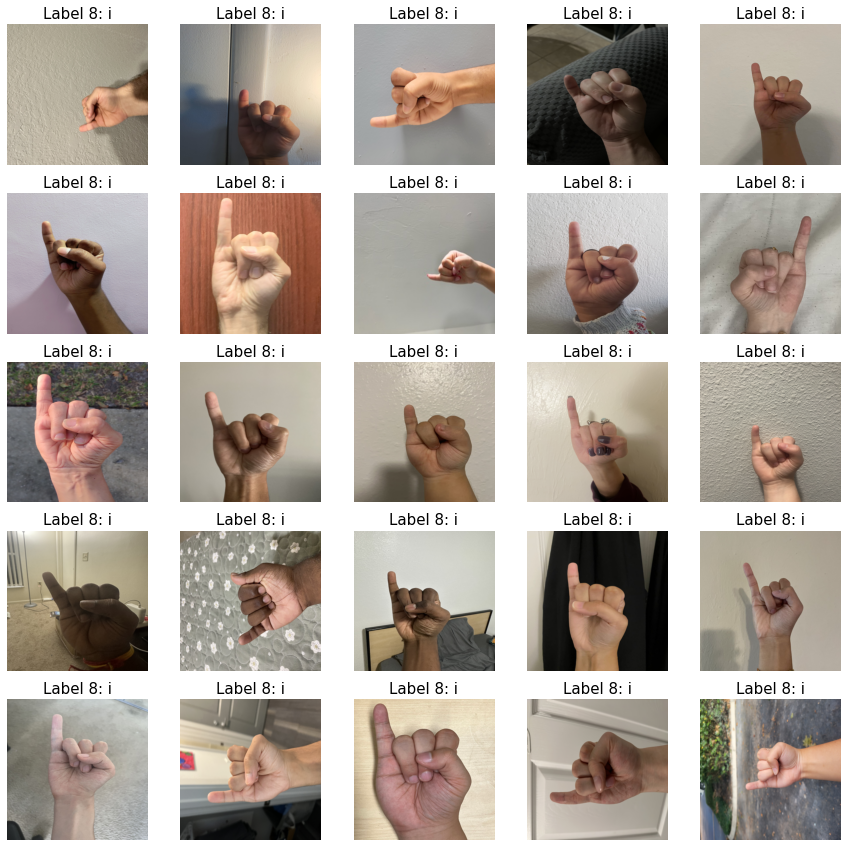

In [6]:
# Displaying some examples per class

for i in range(0,9):
    rnd_sample = npr.permutation(np.where(labels_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(25):
        fig.add_subplot(5,5,j+1)
        plt.imshow(data_train[:,rnd_sample[j]].reshape((300,300,3)))
        label_idx = int(labels_train[rnd_sample[j]])
        plt.axis('off');plt.title('Label '+str(label_idx)+': '+labels_names[label_idx],size=15)
    plt.show()
    print('\n\n')

In [7]:
data_train.shape

(270000, 8443)

## Implementation of Model via VGG16

In [21]:
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def load_and_preprocess_data(data_path, labels_path):
    data_train = np.load(data_path)
    labels_train = np.load(labels_path)

    data_train = data_train.T  # Transpose data_train so that each image is a row

    # Split the data into training, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split(data_train, labels_train, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train, num_classes=9)
    y_val_cat = to_categorical(y_val, num_classes=9)
    y_test_cat = to_categorical(y_test, num_classes=9)

    return X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat


    return X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat

def image_batch_generator(data, labels, batch_size, img_dim=(300, 300)):
    total_samples = data.shape[0]
    while True:
        for start in range(0, total_samples, batch_size):
            end = min(start + batch_size, total_samples)
            batch_data = data[start:end]
            batch_images = batch_data.reshape(-1, img_dim[0], img_dim[1], 3)
            batch_images = batch_images.astype('float32') / 255.0
            batch_labels = labels[start:end]
            yield batch_images, batch_labels


def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-5:]:
        layer.trainable = True


    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(9, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


def train_model(model, train_generator, validation_generator, steps_per_epoch, validation_steps):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )

    # Extracting the training and validation accuracies
    training_accuracy = history.history['accuracy'][-1]
    validation_accuracy = history.history['val_accuracy'][-1]

    return model, training_accuracy, validation_accuracy



def save_model(model, file_path):
    model.save(file_path)



In [2]:
from sklearn.metrics import accuracy_score

def evaluate_model_accuracy(model, test_data, test_labels, batch_size):
    test_generator = image_batch_generator(test_data, test_labels, batch_size)
    steps = np.ceil(len(test_data) / batch_size)

    predictions = model.predict(test_generator, steps=steps)
    predicted_labels = np.argmax(predictions, axis=1)

    true_labels = np.argmax(test_labels, axis=1)  
    accuracy = accuracy_score(true_labels, predicted_labels)

    return accuracy


In [22]:
# Main script
if __name__ == '__main__':
    # Load and preprocess data
    X_train, X_val, X_test, y_train_cat, y_val_cat, y_test_cat = load_and_preprocess_data('data_train.npy', 'labels_train.npy')

    # Create generators
    batch_size = 32
    train_generator = image_batch_generator(X_train, y_train_cat, batch_size)
    validation_generator = image_batch_generator(X_val, y_val_cat, batch_size)

    # Build and train model
    model = build_model()
    steps_per_epoch = len(X_train) // batch_size
    validation_steps = len(X_val) // batch_size

    model, training_accuracy, validation_accuracy = train_model(
        model, train_generator, validation_generator, steps_per_epoch, validation_steps
    )

    # Print training and validation accuracy
    print(f"Training Accuracy: {training_accuracy:.2f}")
    print(f"Validation Accuracy: {validation_accuracy:.2f}")

    # Evaluate model accuracy on test set
    test_accuracy = evaluate_model_accuracy(model, X_test, y_test_cat, batch_size)
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Save the model
    model.save('model.h5')


Epoch 1/100
158/158 [==============================] - 8s 47ms/step - loss: 6.6389 - accuracy: 0.6481 - val_loss: 1.6454 - val_accuracy: 0.8347
Epoch 2/100
158/158 [==============================] - 7s 47ms/step - loss: 1.1486 - accuracy: 0.8939 - val_loss: 1.0814 - val_accuracy: 0.8504
Epoch 3/100
158/158 [==============================] - 7s 46ms/step - loss: 0.6475 - accuracy: 0.9452 - val_loss: 0.6424 - val_accuracy: 0.9153
Epoch 4/100
158/158 [==============================] - 7s 46ms/step - loss: 0.4106 - accuracy: 0.9652 - val_loss: 0.5525 - val_accuracy: 0.9147
Epoch 5/100
158/158 [==============================] - 7s 46ms/step - loss: 0.2885 - accuracy: 0.9710 - val_loss: 0.5551 - val_accuracy: 0.9002
Epoch 6/100
158/158 [==============================] - 7s 47ms/step - loss: 0.2051 - accuracy: 0.9783 - val_loss: 0.4831 - val_accuracy: 0.9183
Epoch 7/100
158/158 [==============================] - 7s 47ms/step - loss: 0.1665 - accuracy: 0.9815 - val_loss: 0.4671 - val_accuracy:

In [4]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
test_accuracy = evaluate_model_accuracy(model, X_test, y_test_cat, batch_size)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.93


Checking custom images

In [26]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('model.h5')

# Load the custom image
custom_image_path = '8.jpeg'  # Replace with the path to your custom image
custom_image = image.load_img(custom_image_path, target_size=(300, 300)) 

# Convert the image to a numpy array
custom_image_array = image.img_to_array(custom_image)

# Reshape and preprocess the image
custom_image_array = np.expand_dims(custom_image_array, axis=0)  # Add a batch dimension
custom_image_array = preprocess_input(custom_image_array)  # Normalize the image

# Make predictions on the custom image
predictions = model.predict(custom_image_array)

# Convert predictions to class label
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class label
print("Predicted class:", predicted_class)


Predicted class: [8]
